In [1]:
import sys
sys.path.append('../..')

from torch.utils.data import DataLoader, TensorDataset

from diffusion_1d.core.ddpm_1d import DDPM
from diffusion_1d.core.noise_scheduler_1d import DDPMScheduler
from diffusion_1d.models.unet_1d import SimpleUNet
from diffusion_1d.data.synthetic import create_toy_dataset
from diffusion_1d.evaluation.visualization import *



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/jantinebroek/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/jantinebroek/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/jantinebroek/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/ipykernel/kernelapp.py

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Create small dataset for quick testing
dataset = create_toy_dataset(n_samples=100, seq_len=32)
dataloader = DataLoader(TensorDataset(dataset), batch_size=8, shuffle=True)

# Get samples and unpack immediately
samples_tuple = next(iter(dataloader))
samples = samples_tuple[0]  # Unpack the tensor from TensorDataset wrapper


In [4]:
# Initialize components
scheduler = DDPMScheduler(num_timesteps=100)  # Fewer steps for quick demo
model = SimpleUNet(dim=32, channels=1).to(device)
ddpm = DDPM(model, scheduler, device)

RuntimeError: Numpy is not available

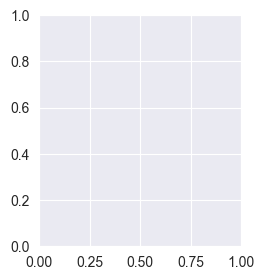

In [5]:
# Visualize original data
plt.figure(figsize=(12, 3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(samples[i, 0].numpy())
    plt.title(f'Original {i+1}')
plt.suptitle('Original Training Data')
plt.show()

In [6]:
# Quick training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):  # Just a few epochs for demo
    model.train()
    total_loss = 0

    for data_tuple in dataloader:
        # Unpack data from TensorDataset
        data = data_tuple[0]  # Unpack from TensorDataset

        # Debug: Print shapes to identify the issue
        print(f"Data tuple type: {type(data_tuple)}")
        print(f"Data tuple length: {len(data_tuple)}")
        print(f"Raw data shape: {data.shape}")

        data = data.to(device)
        print(f"Data shape after .to(device): {data.shape}")

        # This should be [8, 1, 32]
        if data.shape[1] != 1:
            print(f"ERROR: Expected 1 channel, got {data.shape[1]} channels")
            break

        loss = ddpm.train_loss(data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss/len(dataloader):.4f}")

# Cell 5: Generate samples
visualize_final_samples(ddpm, device, num_samples=4, seq_len=32)

Data tuple type: <class 'list'>
Data tuple length: 1
Raw data shape: torch.Size([8, 1, 32])
Data shape after .to(device): torch.Size([8, 1, 32])
DDPM train_loss input shape: torch.Size([8, 1, 32])


RuntimeError: Given groups=1, weight of size [32, 1, 3], expected input[8, 8, 32] to have 1 channels, but got 8 channels instead